In [ ]:
!nvidia-smi

Sun Oct 29 16:52:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    35W /  70W |   2797MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
import numpy as np
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd
import time
import random

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score

# Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.transforms.functional as F

class SquarePad:
    def __init__(self, fill=0, padding_mode="constant"):
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [
            max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])
        ]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, fill=self.fill, padding_mode=self.padding_mode)
def is_png_file(filename):
    return filename.endswith('.png')

transforms = T.Compose([SquarePad(), T.Resize(32), T.ToTensor()])
#dataset = ImageFolder("AquaDataset", transform=transforms)
dataset = ImageFolder("/content/drive/MyDrive/aqua_data", transform=transforms,is_valid_file=is_png_file)



In [ ]:
size_of_dataset = len(dataset)
print(f"Size of the dataset: {size_of_dataset} samples")


Size of the dataset: 88049 samples


Performance Metrices

In [ ]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))

def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)

    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)

    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)

    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)

    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)

    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence,
                            spec=specificity,sens=sensitivity, ppv=get_ppv,
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["Injury", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [class_labels[i],
                     round(tp(y[:, i], pred[:, i]),3),
                     round(tn(y[:, i], pred[:, i]),3),
                     round(fp(y[:, i], pred[:, i]),3),
                     round(fn(y[:, i], pred[:, i]),3),
                     round(acc(y[:, i], pred[:, i], thresholds[i]),3),
                     round(prevalence(y[:, i]),3),
                     round(sens(y[:, i], pred[:, i], thresholds[i]),3),
                     round(spec(y[:, i], pred[:, i], thresholds[i]),3),
                     round(ppv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(npv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(auc(y[:, i], pred[:, i]),3),
                     round(f1(y[:, i], pred[:, i] > thresholds[i]),3),
                     round(thresholds[i], 3)]

    df = df.set_index("Injury")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):

    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


In [ ]:
#Accuracy

def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()


#Loss
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()


#ROC

def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#Precision and Recall
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()


#Confusion Matrix
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()


##04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metric][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2

        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

Augmentation

In [ ]:
##CutOut


class Cutout(nn.Module):
    def __init__(self, seed = 0):
        self.seed = seed

    def get_start_index(self,L):
        return np.random.randint(L)

    def __call__(self,frame):
        channels, h, w = frame.shape
        #print(frames.shape)
        size = h//4
        n_squares = np.random.randint(1,3,1)[0]
        new_image = frame
        for _ in range(n_squares):
            y = np.clip(self.get_start_index(h), size // 2, h - size//2)
            x = np.clip(self.get_start_index(w), size // 2, w - size//2)

            y1 = np.clip(y - size // 2, 0, h)
            y2 = np.clip(y + size // 2, 0, h)
            x1 = np.clip(x - size // 2, 0, w)
            x2 = np.clip(x + size // 2, 0, w)
            new_image[:, y1:y2,x1:x2] = 0
        return new_image

In [ ]:
#Gaussian Noise

class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



In [ ]:
from tqdm import tqdm

l = [X for X,y in tqdm(dataset)]

100%|██████████| 88049/88049 [3:29:31<00:00,  7.00it/s]


In [ ]:
import torch
images__ = torch.stack(l, dim=0)

In [ ]:
labels__ = torch.tensor([y for X,y in tqdm(dataset)])


100%|██████████| 88049/88049 [01:57<00:00, 747.89it/s]


In [ ]:
# 2. Split the data into training and testing sets
images, testimages, labels, testlabels = train_test_split(images__, labels__, test_size=0.2, random_state=42)
print(images.shape, labels.shape)
print(testimages.shape, testlabels.shape)


torch.Size([70439, 3, 32, 32]) torch.Size([70439])
torch.Size([17610, 3, 32, 32]) torch.Size([17610])


In [ ]:
print(images.shape, labels.shape)
print(testimages.shape, testlabels.shape)

torch.Size([70439, 3, 32, 32]) torch.Size([70439])
torch.Size([17610, 3, 32, 32]) torch.Size([17610])


DataGen

In [ ]:
MEAN = torch.mean(images, dim=(0, 2, 3)).reshape(3, 1, 1)
STD = torch.std(images, dim=(0, 2, 3)).reshape(3, 1, 1)

print(MEAN, STD)

tensor([[[0.1665]],

        [[0.1766]],

        [[0.1715]]]) tensor([[[0.1624]],

        [[0.1693]],

        [[0.1615]]])


In [ ]:
class invDataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = T.Compose([T.RandomHorizontalFlip(0.5),
                                              T.RandomResizedCrop(32,(0.8,1.0)),
                                              T.Compose([T.RandomApply([T.ColorJitter(0.8*self.s,
                                                                    0.8*self.s,
                                                                    0.8*self.s,
                                                                    0.2*self.s)], p = 0.8),
                                                                  T.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self, idx):
        x = self.imgarr[idx]
        # x = x.transpose((2, 0, 1))  # Ensure the shape is (channels, height, width)
        # x = x.astype(np.float32) / 255.0

        # x1 = self.augment(torch.from_numpy(x))
        # x2 = self.augment(torch.from_numpy(x))
        x1 = self.augment(x)
        x2 = self.augment(x)

        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)

        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]



    def preprocess(self, frame):
        # local_mean = MEAN.squeeze().reshape(3, 1, 1)
        # local_std = STD.squeeze().reshape(3, 1, 1)
        # frame = (frame - local_mean) / local_std
        frame = (frame - MEAN) / STD
        return frame


    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):

        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame

        return frame




In [ ]:
dg = invDataGen('train',images) #train_df)
dl = DataLoader(dg,batch_size = 16)

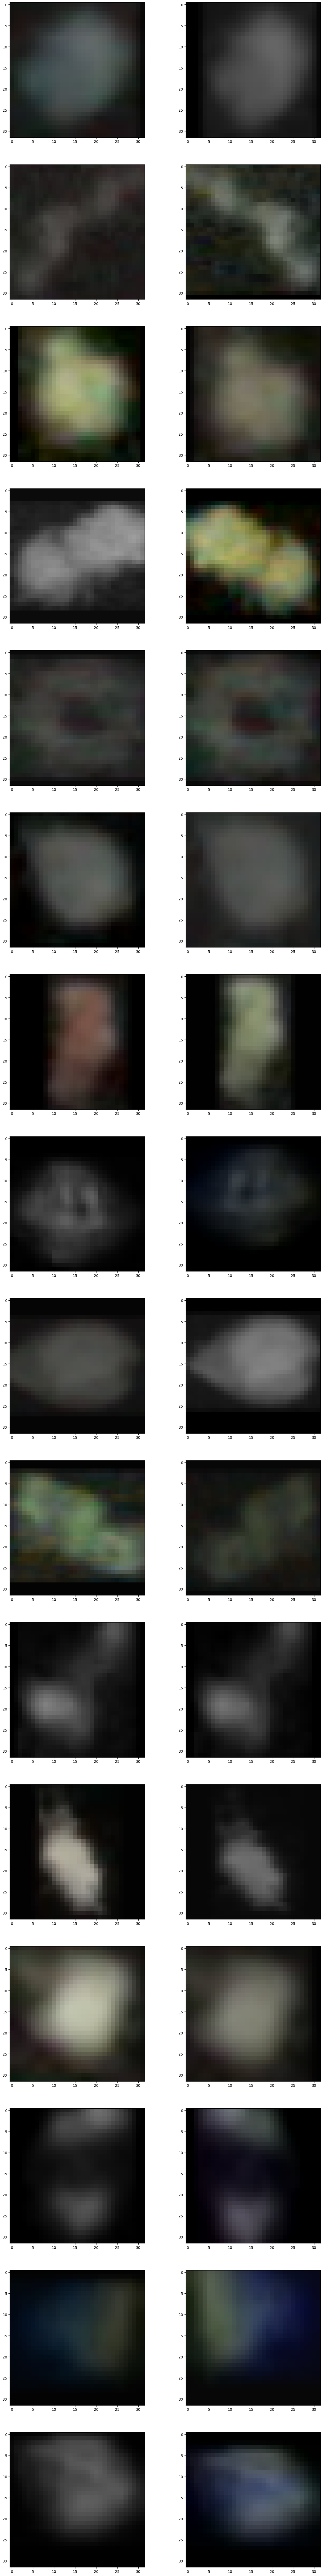

In [ ]:
fig,axs = plt.subplots(16,2,figsize=(16,128))
row = 0
col = 0
for step,(x1,x2) in enumerate(dl):

    for i in range(16):
        # print(x1[i]*STD + MEAN)
        # print(x2[i]*STD + MEAN)
        axs[i,0].imshow((x1[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
        axs[i,1].imshow((x2[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
    break

Model

In [ ]:
import random
random.seed(16)

In [ ]:
#training

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn

        self.linear = nn.Linear(self.in_features,
                                self.out_features,
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))

    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model,base_out_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer

        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()

        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True

        self.projector = ProjectionHead(2048, 2048, 128)


    def forward(self,x):
        out = self.pretrained(x)

        xp = self.projector(torch.squeeze(out))

        return xp




In [ ]:
class PreModel(nn.Module):
    def __init__(self, base_model, base_out_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer

        # PRETRAINED MODEL
        self.pretrained = models.resnet18(pretrained=True)  # Changed to ResNet18 for simplicity and smaller images

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  # Modified for 32x32 input
        self.pretrained.maxpool = Identity()

        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True

        self.projector = ProjectionHead(512, 512, 128)  # Changed the input features according to ResNet18

    def forward(self, x):
        out = self.pretrained(x)
        xp = self.projector(torch.squeeze(out))
        return xp

In [ ]:
import torch

model = PreModel('resnet18', 'avgpool')
if torch.cuda.is_available():
    model = model.to('cuda:0')
else:
    print("CUDA is not available.")




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

PreModel(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [ ]:
print(torch.cuda.is_available())


True


In [ ]:
model = model.cuda()


In [ ]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):


    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):


        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    #device = g_norm.device
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True


In [ ]:
#Optimizer

def load_optimizer(arg_optimizer, model, batch_size):

    scheduler = None
    if arg_optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # TODO: LARS
    elif arg_optimizer == "LARS":
        # optimized using LARS with linear learning rate scaling
        # (i.e. LearningRate = 0.3 × BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * batch_size / 256
        optimizer = LARS(
            [params for params in model.parameters() if params.requires_grad],
            lr=0.1,
            weight_decay=1e-6,
            exclude_from_weight_decay=["batch_normalization", "bias"],
        )

        # "decay the learning rate with the cosine decay schedule without restarts"
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, epochs, eta_min=0, last_epoch=-1
        )
    else:
        raise NotImplementedError

    return optimizer, scheduler


In [ ]:
#Loss

class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__()  # Fixed the class name here
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size

        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        #print(sim.shape)

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)


        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)


        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss




In [ ]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


In [ ]:
criterion = SimCLR_Loss(batch_size=128, temperature=0.5)

In [ ]:
trimages = images[:3500]
valimages = images[3500:]
trlabels = labels[:3500]
vallabels = labels[3500:]

In [ ]:
dg = invDataGen('train', trimages)  # Adjust the slice as per your requirement
dl = DataLoader(dg, batch_size=128, drop_last=True)

In [ ]:
vdg = invDataGen('valid',valimages)#_df)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

Train

In [ ]:
nr = 0
global_step = 0
current_epoch = 0
epochs = 50


In [ ]:
def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)#.view((-1,3,224,224))

            #x1 = x1.squeeze().to(dtype = torch.float)#.view((-1,3,224,224))
            #y = y.to(device = 'cuda:0')#.view((-1,1))
            out = model(x1)
            out = out.cuda().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)

    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    #plt.scatter(x_feats[:,1],x_feats[:,0])
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)

    for i in range(num_classes):
        #plt.scatter(x_feats[val_df['class'].iloc[:num_samples].values==i,1],x_feats[val_df['class'].iloc[:num_samples].values==i,0])
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])

    plt.legend([str(i) for i in range(num_classes)])
    plt.show()



In [ ]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0

    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        # x_i = x_i.squeeze().float()
        # x_j = x_j.squeeze().float()
        x_i = x_i.squeeze().float().cuda()
        x_j = x_j.squeeze().float().cuda()


        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch




In [ ]:
def valid(valid_loader, model, criterion):
    if len(valid_loader) == 0:
        print("Warning: Validation loader is empty!")
        return 0  # or return None, or raise an exception, or handle this case appropriately

    loss_epoch = 0
    for step, (x_i, x_j) in enumerate(valid_loader):

        x_i = x_i.squeeze().float().cuda()
        x_j = x_j.squeeze().float().cuda()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)

        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch




In [ ]:
tr_loss = []
val_loss = []



In [ ]:
for epoch in range(50):

    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dl, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()

    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vdl, model, criterion)

    if nr == 0:

        tr_loss.append(tr_loss_epoch / len(dl))

        if len(vdl) > 0:
            val_loss.append(val_loss_epoch / len(vdl))
        else:
            print("Validation data loader is empty.")
            val_loss.append(0)  # Handle this as per your need


        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}"
        )
        if len(vdl) > 0:
            print(
                f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}"
            )
        else:
            print("Validation DataLoader is empty.")

        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    # if (epoch+1)%10==0:
    #     plot_features(model.pretrained, 2, 2048, 128) #, valimages)



Epoch [0/50]	
Step [0/27]	 Loss: 3.68621
Adjusting learning rate of group 0 to 4.4000e-01.
Step [0/522]	 Loss: 3.64764
Step [50/522]	 Loss: 3.64566
Step [100/522]	 Loss: 3.64646
Step [150/522]	 Loss: 3.63856
Step [200/522]	 Loss: 3.64038
Step [250/522]	 Loss: 3.64942
Step [300/522]	 Loss: 3.64228
Step [350/522]	 Loss: 3.65039
Step [400/522]	 Loss: 3.64651
Step [450/522]	 Loss: 3.64051
Step [500/522]	 Loss: 3.66338
Epoch [0/50]	 Training Loss: 3.6847411349967674	 lr: 0.44
Epoch [0/50]	 Validation Loss: 3.6459089047150592	 lr: 0.44
Epoch [0/50]	 Time Taken: 0.9078883449236552 minutes
Epoch [1/50]	
Step [0/27]	 Loss: 3.68457
Adjusting learning rate of group 0 to 4.6000e-01.
Step [0/522]	 Loss: 3.64716
Step [50/522]	 Loss: 3.6433
Step [100/522]	 Loss: 3.63978
Step [150/522]	 Loss: 3.63454
Step [200/522]	 Loss: 3.64058
Step [250/522]	 Loss: 3.65167
Step [300/522]	 Loss: 3.63937
Step [350/522]	 Loss: 3.65652
Step [400/522]	 Loss: 3.64602
Step [450/522]	 Loss: 3.63989
Step [500/522]	 Loss: 3.

NameError: ignored

In [ ]:
np.unique(vallabels)

array([0, 1])

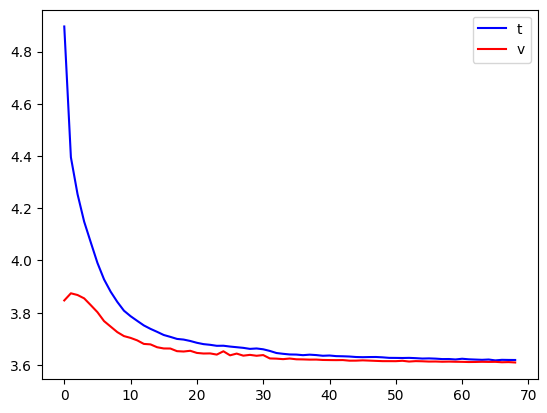

In [ ]:
plt.plot(tr_loss,'b-')
plt.plot(val_loss,'r-')
plt.legend(['t','v'])
plt.show()

Downstream

In [ ]:
class DSModel(nn.Module):
    def __init__(self, premodel, num_classes):
        super().__init__()

        self.premodel = premodel
        self.num_classes = num_classes

        for p in self.premodel.parameters():
            p.requires_grad = False

        self.lastlayer = nn.Linear(512, self.num_classes)  # Changed the input feature number

    def forward(self, x):
        out = self.premodel.pretrained(x)
        out = self.lastlayer(out)
        return out


In [ ]:
NUM_FRAMES = 16
# NUM_CLASSES = len(set(testlabels))
NUM_CLASSES= 2
print(NUM_CLASSES)


2


In [ ]:
random.seed(16)
dsmodel = DSModel(model, NUM_CLASSES ).to('cuda:0')


In [ ]:
class DSDataGen(Dataset):
    def __init__(self, phase, imgarr, labels, num_classes=NUM_CLASSES):
        self.phase = phase
        self.imgarr = imgarr
        self.labels = labels
        self.num_classes = num_classes
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(0.5),
            T.RandomResizedCrop(32, (0.8, 1.0)),
            T.Compose([
                T.RandomApply([
                    T.ColorJitter(0.8 * 0.5,  # Using s=0.5 here as placeholder
                                  0.8 * 0.5,
                                  0.8 * 0.5,
                                  0.2 * 0.5)
                ], p=0.8),
                T.RandomGrayscale(p=0.2)
            ])
        ])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self, idx):
        x = self.imgarr[idx]
        if self.phase == 'train':
            x = self.augment(x)
        x = self.preprocess(x)
        label = self.labels[idx]
        return x, label

    def preprocess(self, frame):
        frame = (frame - MEAN) / STD
        return frame

    def augment(self, frame):
        frame = self.transforms(frame)
        return frame

In [ ]:
# Creating data generators for training, validation, and test datasets
dg = DSDataGen('train', trimages, trlabels)
dl = DataLoader(dg, batch_size=32, drop_last=True)

vdg = DSDataGen('valid', valimages, vallabels)
vdl = DataLoader(vdg, batch_size=32, drop_last=True)

# tdg = DSDataGen('test', testimages, testlabels)  # testimages and testlabels should be defined and loaded beforehand
# tdl = DataLoader(tdg, batch_size=32, drop_last=True)

tdg = DSDataGen('test', testimages, testlabels)
tdl = DataLoader(tdg, batch_size=32, drop_last=True)



In [ ]:
dsoptimizer = torch.optim.SGD([params for params in dsmodel.parameters() if params.requires_grad],lr = 0.01, momentum = 0.9)

#dsoptimizer = torch.optim.Adam([params for params in dsmodel.parameters() if params.requires_grad],lr=1e-5)

lr_scheduler = torch.optim.lr_scheduler.StepLR(dsoptimizer, step_size=1, gamma=0.98, last_epoch=-1, verbose = True)

#CosineAnnealingWarmRestarts(dsoptimizer,5,eta_min = 1e-6,last_epoch = -1, verbose = True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
loss_fn = nn.CrossEntropyLoss()
tr_ep_loss = []
tr_ep_acc = []
tr_ep_auc = []
val_ep_loss = []
val_ep_acc = []
val_ep_auc = []

min_val_loss = 100.0

batch_size = 1
EPOCHS = 50
num_cl = 2
accumulation_steps = 1



In [ ]:
for epoch in range(50):

    stime = time.time()
    print("=============== Epoch : %3d ==============="%(epoch+1))

    loss_sublist = np.array([])
    acc_sublist = np.array([])

    #iter_num = 0
    dsmodel.train()

    dsoptimizer.zero_grad()

    for x,y in dl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')

        z = dsmodel(x)

        dsoptimizer.zero_grad()

        tr_loss = loss_fn(z,y) #/accumulation_steps #y.to(dtype=torch.float), z)
        tr_loss.backward()

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

        #if (iter_num+1)%accumulation_steps==0:
        dsoptimizer.step()
        #dsoptimizer.zero_grad()

        loss_sublist = np.append(loss_sublist, tr_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)

        #iter_num+=1

    print('ESTIMATING TRAINING METRICS.............')

    print('TRAINING BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist)*accumulation_steps)
    print('TRAINING BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('TRAINING AUC SCORE: ',roc_auc_score(gt,preds))

    tr_ep_loss.append(np.mean(loss_sublist))
    tr_ep_acc.append(np.mean(acc_sublist))

    #tr_ep_auc.append(roc_auc_score(gt, preds))



    print('ESTIMATING VALIDATION METRICS.............')

    dsmodel.eval()

    loss_sublist = np.array([])
    acc_sublist = np.array([])

    with torch.no_grad():
        for x,y in vdl:
            x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
            y = y.to(device = 'cuda:0')
            z = dsmodel(x)

            val_loss = loss_fn(z,y)

            preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

            loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
            acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)


    print('VALIDATION BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
    print('VALIDATION BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('VALIDATION AUC SCORE: ',roc_auc_score(gt, preds))

    val_ep_loss.append(np.mean(loss_sublist))
    val_ep_acc.append(np.mean(acc_sublist))

    #val_ep_auc.append(roc_auc_score(gt, preds))

    lr_scheduler.step()

    #dg.on_epoch_end()

    if np.mean(loss_sublist) <= min_val_loss:
        min_val_loss = np.mean(loss_sublist)
        print('Saving model...')
        # torch.save({'model_state_dict': dsmodel.state_dict(),
        #         'optimizer_state_dict': dsoptimizer.state_dict()},
        #        '/content/saved_models/cifar10_rn50_p128_sgd0p01_decay0p98_all_lincls_300621.pt')

    print("Time Taken : %.2f minutes"%((time.time()-stime)/60.0))

=============== Epoch :   1 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  0.4542402301086198
TRAINING BINARY ACCURACY:  0.8592316513761468
ESTIMATING VALIDATION METRICS.............
VALIDATION BINARY CROSSENTROPY LOSS:  0.309066769364546
VALIDATION BINARY ACCURACY:  0.8863432568149211
Adjusting learning rate of group 0 to 9.8000e-03.
Saving model...
Time Taken : 0.46 minutes
=============== Epoch :   2 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  0.3572412807870349
TRAINING BINARY ACCURACY:  0.8830275229357798
ESTIMATING VALIDATION METRICS.............
VALIDATION BINARY CROSSENTROPY LOSS:  0.3160781572634797
VALIDATION BINARY ACCURACY:  0.8885700621712099
Adjusting learning rate of group 0 to 9.6040e-03.
Time Taken : 0.45 minutes
=============== Epoch :   3 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  0.34091358249067166
TRAINING BINARY ACCURACY

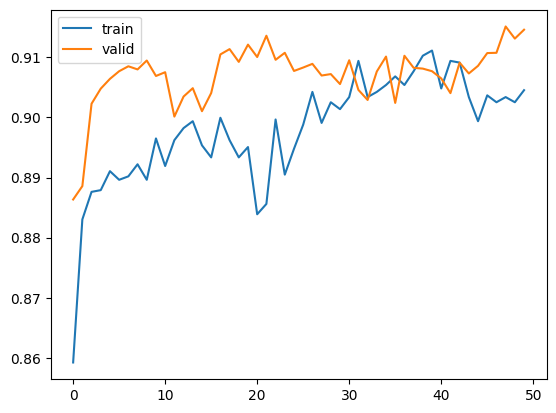

In [ ]:
plt.plot([t for t in tr_ep_acc])
plt.plot([t for t in val_ep_acc])
plt.legend(['train','valid'])

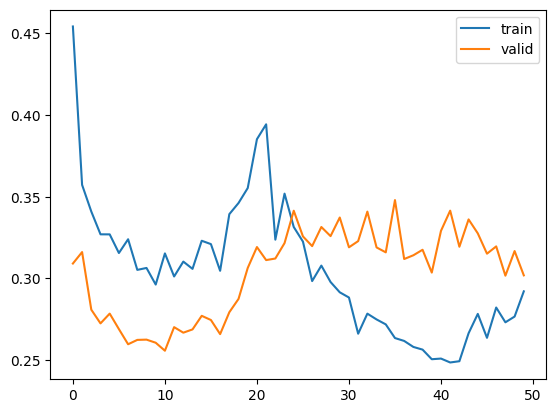

In [ ]:
plt.plot(tr_ep_loss)
plt.plot(val_ep_loss)
plt.legend(['train','valid'])

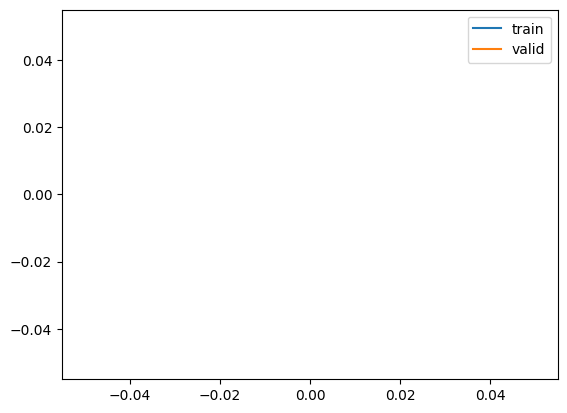

In [ ]:
plt.plot([t for t in tr_ep_auc])
plt.plot([t for t in val_ep_auc])
plt.legend(['train','valid'])

In [ ]:
tdg = DSDataGen('test', testimages, testlabels, num_classes=2)

tdl = DataLoader(tdg, batch_size = 32, drop_last = True)

dsmodel.eval()

loss_sublist = np.array([])
acc_sublist = np.array([])

with torch.no_grad():
    for x,y in vdl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')
        z = dsmodel(x)

        val_loss = loss_fn(z,y)

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

        loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)

print('TEST BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
print('TEST BINARY ACCURACY: ',np.mean(acc_sublist))

TEST BINARY CROSSENTROPY LOSS:  0.30182803551087867
TEST BINARY ACCURACY:  0.9145893113342898
